# Proyecto: Segmentación Estratégica de Clientes (K-Means Clustering)


## FASE 1: Entendimiento del Negocio y Configuracion

## Contexto del Problema
Un centro comercial desea identificar grupos de clientes con comportamientos similares para personalizar sus estrategias de marketing. El objetivo es optimizar el presupuesto de campañas enfocándose en los clientes con mayor potencial de compra y fidelidad.

**Objetivo Técnico:** Utilizar el algoritmo no supervisado K-Means para agrupar clientes basándose en sus Ingresos Anuales y su "Spending Score".

In [ ]:
import warnings
import os
# Esta línea soluciona el error de memoria en Windows y silencia las advertencias
os.environ['OMP_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

# Importación de librerías esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Configuración estética
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Carga de datos
df = pd.read_csv('Mall_Customers.csv')

# Limpieza inicial: Renombrar columnas para facilitar el manejo
df.rename(columns={'Genre': 'Gender'}, inplace=True)

# Vista cabezera
print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## 2. Cargar y Auditoria
Vamos a cargar el archivo Mall_Customers.cvs y hora haremos unas correciones.

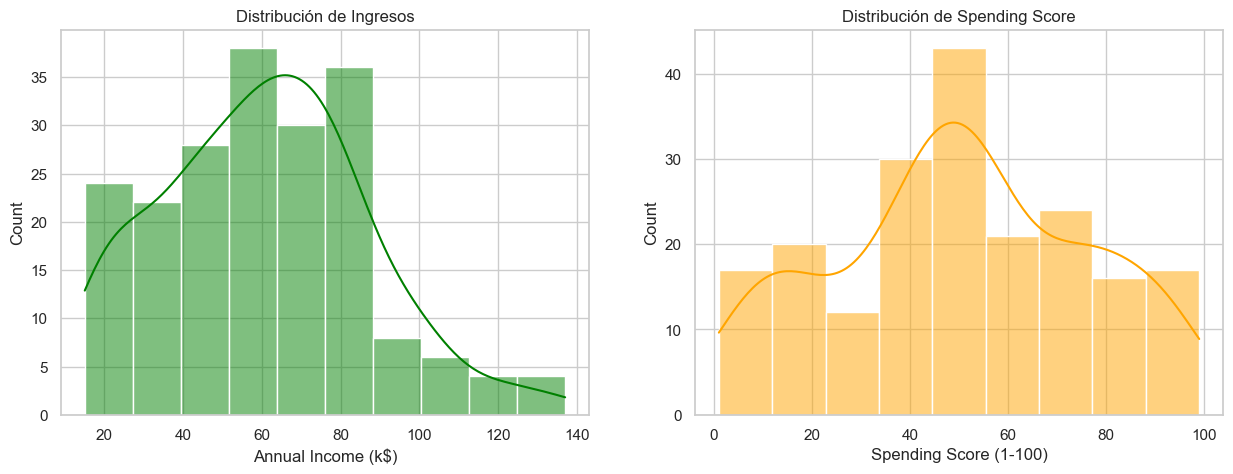

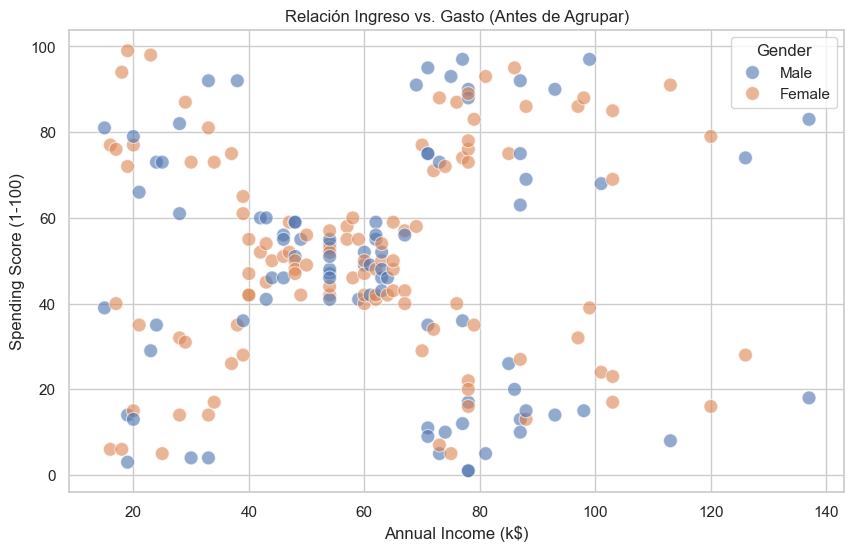

In [ ]:
# 1. Distribución de las variables principales
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Annual Income (k$)'], kde=True, color='green')
plt.title('Distribución de Ingresos')

plt.subplot(1, 2, 2)
sns.histplot(df['Spending Score (1-100)'], kde=True, color='orange')
plt.title('Distribución de Spending Score')
plt.show()

# 2. Análisis Bivariado: ¿Vemos grupos a simple vista?
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Gender', s=100, alpha=0.6)
plt.title('Relación Ingreso vs. Gasto (Antes de Agrupar)')
plt.show()

## FASE 3: Preprocesamiento e Ingeniería de Características
El algoritmo K-Means es sensible a la escala de los datos (calcula distancias). Es crucial estandarizar las variables para que los "Ingresos" (ej. 15,000) no dominen sobre el "Score" (ej. 1-100).

In [ ]:
# Selección de variables para el modelo (Ingresos y Score)
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Estandarización (Escalado)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Verificación (Media debe ser ~0 y Desviación ~1)
pd.DataFrame(X_scaled, columns=X.columns).describe().round(2).T.iloc[:, 1:3]

,mean,std
Annual Income (k$),-0.0,1.0
Spending Score (1-100),-0.0,1.0


## 4. Visualizacion: Distribuciones
Vamos a ver la "Forma" de los datos generando graficos de distribucion.

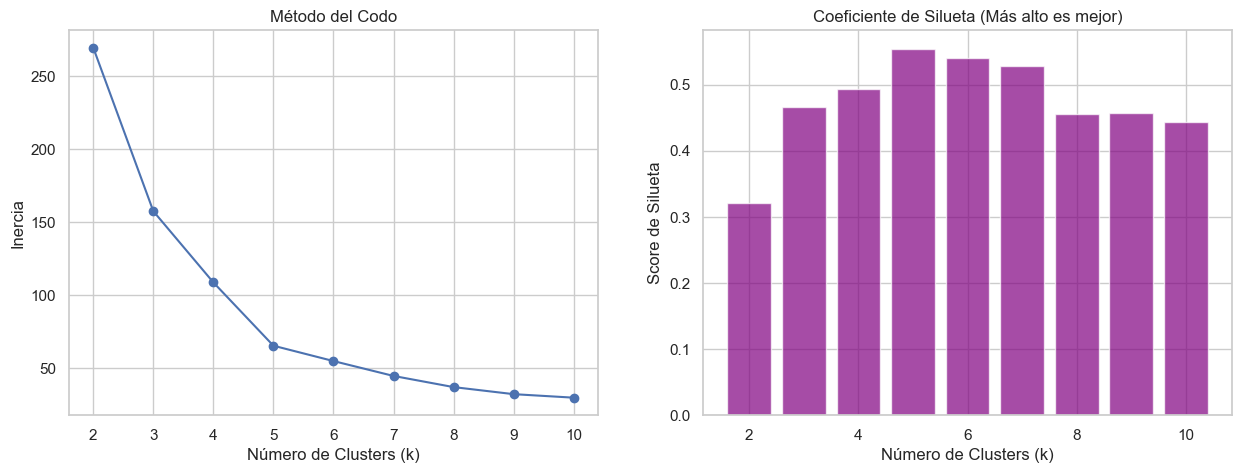

Observamos que K=5 ofrece un buen balance entre inercia y separación.


In [ ]:
# Cálculo de Inercia y Silueta para K de 2 a 10
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Gráfica del Método del Codo
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')

# Gráfica de Silueta
plt.subplot(1, 2, 2)
plt.bar(k_range, silhouette_scores, color='purple', alpha=0.7)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Score de Silueta')
plt.title('Coeficiente de Silueta (Más alto es mejor)')
plt.show()

print(f"Observamos que K=5 ofrece un buen balance entre inercia y separación.")

## FASE 5: Interpretación y Perfilamiento de Clientes
Entrenamos el modelo final con **K=5** y analizamos las características de cada grupo para diseñar estrategias.

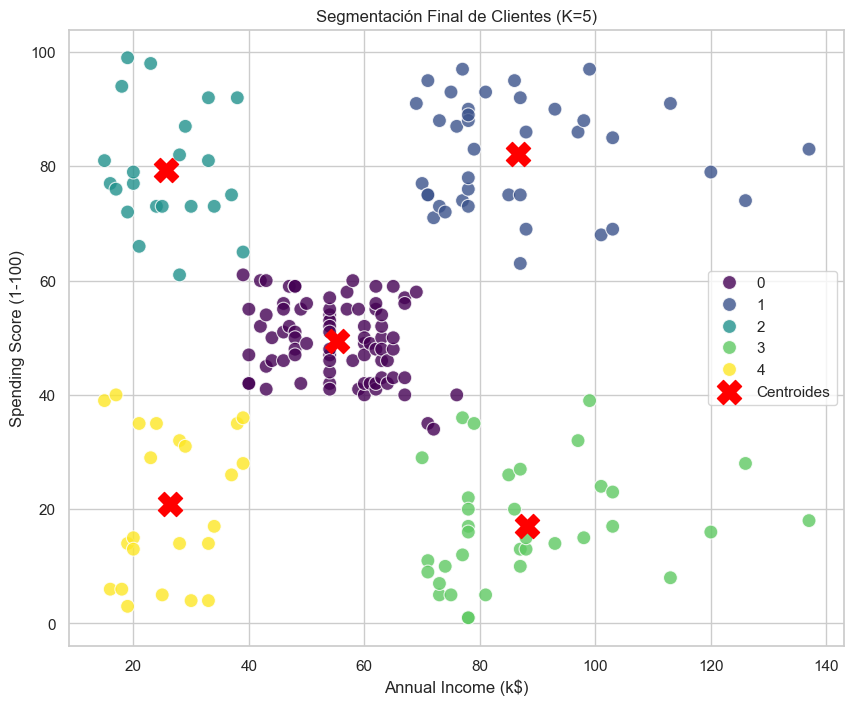

,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,
0,42.7,55.3,49.5
1,32.7,86.5,82.1
2,25.3,25.7,79.4
3,41.1,88.2,17.1
4,45.2,26.3,20.9


In [ ]:
# 1. Entrenamiento Final
kmeans_final = KMeans(n_clusters=5, random_state=42, n_init=10)
df['Cluster'] = kmeans_final.fit_predict(X_scaled)

# 2. Visualización Final de Segmentos
plt.figure(figsize=(10, 8))

# Asegúrate de que los argumentos estén alineados y sin caracteres extraños
sns.scatterplot(
    data=df,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='Cluster',
    palette='viridis',
    s=100,
    alpha=0.8
)

# Graficar Centroides
centers = scaler.inverse_transform(kmeans_final.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=300, marker='X', label='Centroides')

plt.title('Segmentación Final de Clientes (K=5)')
plt.legend()
plt.show()

# 3. Resumen estadístico por Cluster
display(df.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(1))

### Estrategia de Negocio Sugerida:

Basado en el análisis de los 5 clusters, recomendamos:

1.  **Cluster VIP (Ingreso Alto, Gasto Alto):** *Estrategia:* Fidelización exclusiva, acceso anticipado a nuevas colecciones y eventos privados.
2.  **Cluster Objetivo (Ingreso Medio, Gasto Medio):** *Estrategia:* Promociones estándar para aumentar el ticket promedio.
3.  **Cluster Ahorradores (Ingreso Alto, Gasto Bajo):** *Estrategia:* Campañas de marketing racional, destacando calidad/precio y ofertas premium para "desbloquear" su potencial de gasto.
4.  **Cluster Despreocupados (Ingreso Bajo, Gasto Alto):** *Estrategia:* Descuentos flash y marketing en redes sociales (suelen ser público más joven).
5.  **Cluster Cautelosos (Ingreso Bajo, Gasto Bajo):** *Estrategia:* Cupones de descuento agresivos para atraerlos en temporadas bajas.